# Covid-19 Data Analysis

## Data Source

Source data for this notebook may be found on [GitHub](https://github.com/) at
[covid-19](https://github.com/datasets/covid-19.git).  Additional data may
be found from the [NY Times](https://github.com/nytimes/covid-19-data.git).

In [1]:
%%bash
if [ ! -d covid-19 ]; then
    git clone https://github.com/datasets/covid-19.git
    (cd covid-19; git config pull.rebase false)
else
    (cd covid-19; git pull)
fi

(cd covid-19; git log -n 1)

Already up to date.
commit 1136cb591ef541f968b68ff4db7c6d3b432e70a1
Author: GitHub Action <action@github.com>
Date:   Sun Jun 13 06:11:09 2021 +0000

    Auto-update of the data packages


In [2]:
%%bash
ls covid-19/data

countries-aggregated.csv
key-countries-pivoted.csv
reference.csv
time-series-19-covid-combined.csv
us_confirmed.csv
us_deaths.csv
us_simplified.csv
worldwide-aggregate.csv


# Dependencies

In [3]:
%%pom
---
dependencies:
- org.knowm.xchart:xchart:3.8.0

## Spark

In [4]:
%%scala
import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.types._

val session = SparkSession.builder().master("local").appName("covid-19").getOrCreate()
    
import session.implicits._

display(session);

local
 covid-19

In [5]:
%%scala
val reader = session.read.format("csv").option("header", "true").option("inferSchema", "true")

val countries_aggregated = reader.load("covid-19/data/countries-aggregated.csv")
  .withColumn("Date", $"Date".cast(DateType))
val key_countries_pivoted = reader.load("covid-19/data/key-countries-pivoted.csv")
  .withColumn("Date", $"Date".cast(DateType))
val reference = reader.load("covid-19/data/reference.csv")
val time_series_19_covid_combined = reader.load("covid-19/data/time-series-19-covid-combined.csv")
  .withColumn("Date", $"Date".cast(DateType))
val us_confirmed = reader.load("covid-19/data/us_confirmed.csv")
  .withColumn("Date", $"Date".cast(DateType))
val us_deaths = reader.load("covid-19/data/us_deaths.csv")
  .withColumn("Date", $"Date".cast(DateType))
val us_simplified = reader.load("covid-19/data/us_simplified.csv")
  .withColumn("Date", $"Date".cast(DateType))
val worldwide_aggregate = reader.load("covid-19/data/worldwide-aggregate.csv")
  .withColumn("Date", $"Date".cast(DateType))

In [6]:
%%scala
Console.withOut(System.out) { us_simplified.printSchema }

root
 |-- Date: date (nullable = true)
 |-- Admin2: string (nullable = true)
 |-- Province/State: string (nullable = true)
 |-- Confirmed: integer (nullable = true)
 |-- Deaths: integer (nullable = true)
 |-- Country/Region: string (nullable = true)



In [7]:
%%scala
Console.withOut(System.out) { us_simplified.show(40) }

+----------+-------+--------------+---------+------+--------------+
|      Date| Admin2|Province/State|Confirmed|Deaths|Country/Region|
+----------+-------+--------------+---------+------+--------------+
|2020-01-22|Autauga|       Alabama|        0|     0|            US|
|2020-01-23|Autauga|       Alabama|        0|     0|            US|
|2020-01-24|Autauga|       Alabama|        0|     0|            US|
|2020-01-25|Autauga|       Alabama|        0|     0|            US|
|2020-01-26|Autauga|       Alabama|        0|     0|            US|
|2020-01-27|Autauga|       Alabama|        0|     0|            US|
|2020-01-28|Autauga|       Alabama|        0|     0|            US|
|2020-01-29|Autauga|       Alabama|        0|     0|            US|
|2020-01-30|Autauga|       Alabama|        0|     0|            US|
|2020-01-31|Autauga|       Alabama|        0|     0|            US|
|2020-02-01|Autauga|       Alabama|        0|     0|            US|
|2020-02-02|Autauga|       Alabama|        0|   

In [8]:
%%scala
var by_state = us_simplified
  .groupBy("Country/Region", "Province/State")
  .agg(max("Deaths").as("Deaths"))
  .orderBy(desc("Deaths"))

Console.withOut(System.out) { by_state.show }

+--------------+--------------+------+
|Country/Region|Province/State|Deaths|
+--------------+--------------+------+
|            US|    California| 24440|
|            US|      New York| 10450|
|            US|      Illinois| 10419|
|            US|       Arizona| 10150|
|            US|         Texas|  6503|
|            US|       Florida|  6472|
|            US|      Michigan|  5113|
|            US|        Nevada|  4440|
|            US| Massachusetts|  3770|
|            US|  Pennsylvania|  3726|
|            US|    New Jersey|  3003|
|            US|   Puerto Rico|  2530|
|            US|   Connecticut|  2431|
|            US|      Missouri|  2258|
|            US|          Ohio|  2204|
|            US|  Rhode Island|  1987|
|            US|       Indiana|  1775|
|            US|     Minnesota|  1769|
|            US|     Tennessee|  1671|
|            US|      Maryland|  1666|
+--------------+--------------+------+
only showing top 20 rows



In [9]:
%%scala
var dates = time_series_19_covid_combined.select("Date").distinct().orderBy(asc("Date"))
var interval = dates.agg(min("Date"), max("Date")).head
var snapshot = time_series_19_covid_combined
  .filter($"Date" <= interval.get(1))
  .groupBy($"Country/Region")
  .agg(max($"Deaths").as("Deaths"))
  .orderBy(desc("Deaths"))

Console.withOut(System.out) { snapshot.show(100) }

+--------------------+------+
|      Country/Region|Deaths|
+--------------------+------+
|                  US|599664|
|              Brazil|486272|
|               India|369680|
|              Mexico|230097|
|                Peru|188100|
|      United Kingdom|127896|
|               Italy|126976|
|              Russia|123961|
|              France|109503|
|            Colombia| 95192|
|             Germany| 89841|
|           Argentina| 85075|
|                Iran| 81911|
|               Spain| 80501|
|              Poland| 74562|
|        South Africa| 57706|
|             Ukraine| 53758|
|           Indonesia| 52730|
|              Turkey| 48668|
|             Romania| 31804|
|               Chile| 30579|
|             Czechia| 30224|
|             Hungary| 29904|
|             Belgium| 25081|
|         Philippines| 22652|
|            Pakistan| 21633|
|             Ecuador| 21018|
|            Bulgaria| 17898|
|         Netherlands| 17709|
|            Portugal| 17045|
|         

In [10]:
%%scala
val (countries, deaths) = snapshot.collect.map(r => (r(0).toString, r(1).toString.toInt)).toList.unzip

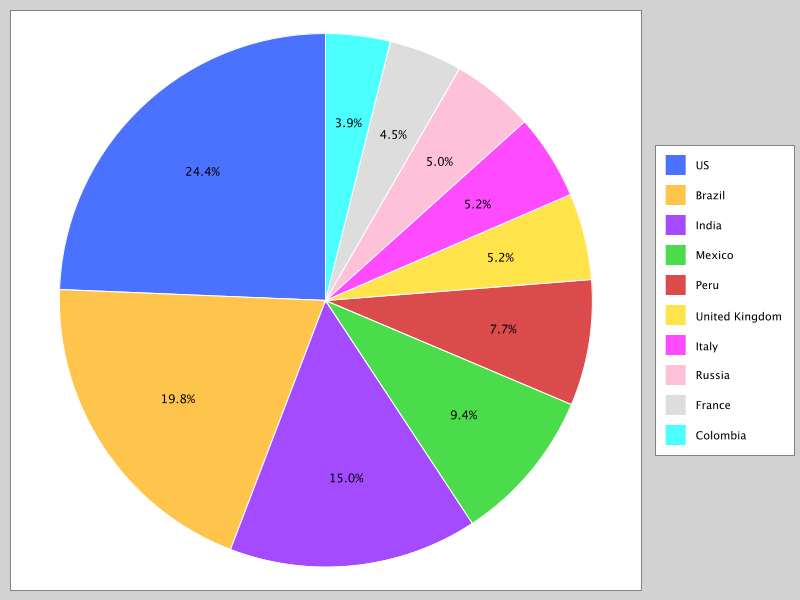

In [11]:
%%scala
import org.knowm.xchart._

var chart = new PieChartBuilder().width(800).height(600).build()

snapshot.collect.slice(0, 10).foreach(r => chart.addSeries(r(0).toString, r(1).toString.toInt))

print(chart)